<a href="https://colab.research.google.com/github/evanzs/curso-spark/blob/master/atividade_aula05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

spark_home ='/content/drive/MyDrive/Colab Notebooks/spark-3.5.1-bin-hadoop3.tgz'

# instalar as dependências
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

!tar xf '/content/drive/MyDrive/Colab Notebooks/spark-3.5.1-bin-hadoop3.tgz'
!pip install -q findspark

# configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

# tornar o pyspark "importável"
import findspark
findspark.init('spark-3.5.1-bin-hadoop3')

from pyspark.sql import SparkSession

## 1. Classe é a coluna class,portando Multiclass
## 2. Utilize MulticlassClassificationEvaluator
## 3. Use accuracy como métrica
## 4. Use um classificador diferente,por exemplo NaiveBayes

In [ ]:
spark = SparkSession.builder.appName("ml").getOrCreate()

## importando classes de ml
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## importando Dados
import pandas as pd
df  = pd.read_csv("https://raw.githubusercontent.com/evanzs/curso-spark/master/datasets/iris.csv",sep=',')
df_iris = spark.createDataFrame(df)
df_iris.show(5)

+-----------+----------+-----------+----------+-----------+
|sepallength|sepalwidth|petallength|petalwidth|      class|
+-----------+----------+-----------+----------+-----------+
|        5.1|       3.5|        1.4|       0.2|Iris-setosa|
|        4.9|       3.0|        1.4|       0.2|Iris-setosa|
|        4.7|       3.2|        1.3|       0.2|Iris-setosa|
|        4.6|       3.1|        1.5|       0.2|Iris-setosa|
|        5.0|       3.6|        1.4|       0.2|Iris-setosa|
+-----------+----------+-----------+----------+-----------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col,isnan, when, count

## avaliando numeros vazios ou nan
df_iris.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+-----------+----------+-----------+----------+-----+
|sepallength|sepalwidth|petallength|petalwidth|class|
+-----------+----------+-----------+----------+-----+
|          0|         0|          0|         0|    0|
+-----------+----------+-----------+----------+-----+



In [ ]:
## avaliando numeros vazios ou nan
df_iris.select([count(when((c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

In [ ]:
df_iris.count()

150

In [ ]:

## analizando duplicatas
df_iris.exceptAll(df_iris.dropDuplicates()).show()

+-----------+----------+-----------+----------+--------------+
|sepallength|sepalwidth|petallength|petalwidth|         class|
+-----------+----------+-----------+----------+--------------+
|        4.9|       3.1|        1.5|       0.1|   Iris-setosa|
|        4.9|       3.1|        1.5|       0.1|   Iris-setosa|
|        5.8|       2.7|        5.1|       1.9|Iris-virginica|
+-----------+----------+-----------+----------+--------------+



In [ ]:
## deletando duplicados

df_iris = df_iris.dropDuplicates()
print("valores duplicados: ",df_iris.exceptAll(df_iris.dropDuplicates()).show())
print("total de valores: ",df_iris.count())

+-----------+----------+-----------+----------+-----+
|sepallength|sepalwidth|petallength|petalwidth|class|
+-----------+----------+-----------+----------+-----+
+-----------+----------+-----------+----------+-----+

valores duplicados:  None
total de valores:  147


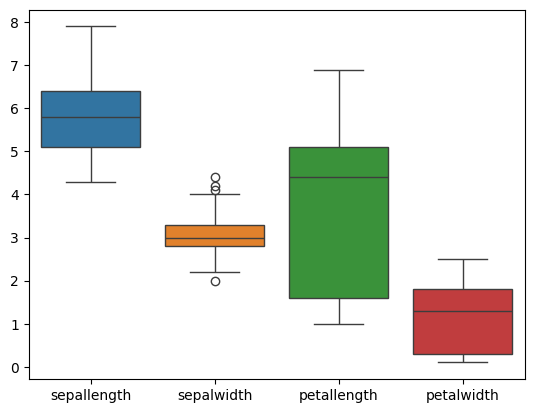

In [24]:
## fazendo uma analise de outliers

import matplotlib.pyplot as plt
import seaborn as sns
data = df_iris.toPandas()
sns.boxplot(data=data)
plt.show()

In [27]:
from pyspark.ml.classification import RandomForestClassifier,NaiveBayes
from pyspark.ml.feature import VectorAssembler



vec_caracteristicas = VectorAssembler(inputCols=cols,outputCol="caracteristicas")
iris_caracteristica = vec_caracteristicas.transform(df_iris)

iris_caracteristica.show(5)



+-----------+----------+-----------+----------+---------------+-----------------+
|sepallength|sepalwidth|petallength|petalwidth|          class|  caracteristicas|
+-----------+----------+-----------+----------+---------------+-----------------+
|        4.6|       3.1|        1.5|       0.2|    Iris-setosa|[4.6,3.1,1.5,0.2]|
|        5.6|       3.0|        4.5|       1.5|Iris-versicolor|[5.6,3.0,4.5,1.5]|
|        6.3|       2.5|        4.9|       1.5|Iris-versicolor|[6.3,2.5,4.9,1.5]|
|        5.8|       4.0|        1.2|       0.2|    Iris-setosa|[5.8,4.0,1.2,0.2]|
|        5.0|       3.0|        1.6|       0.2|    Iris-setosa|[5.0,3.0,1.6,0.2]|
+-----------+----------+-----------+----------+---------------+-----------------+
only showing top 5 rows



In [29]:
splitConfig = [0.7,0.3]
data_train,data_test = iris_caracteristica.randomSplit(splitConfig)

class_random = RandomForestClassifier(featuresCol="caracteristicas", labelCol="class")
model_randomForest = class_random.fit(data_train)
preview_randomForest = model_randomForest.transform(data_test)

## dividindo dataset entre treino e test

preview_randomForest.show(5)


IllegalArgumentException: requirement failed: Column class must be of type numeric but was actually of type string.